<a href="https://colab.research.google.com/github/juhumkwon/Defense_Cloud/blob/main/A_12_0_2_2_yolo_trainning_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 512ms/step - loss: 65.6413
Epoch 2/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 36s 570ms/step - loss: 34.6623
Epoch 3/3
63/63 ━━━━━━━━━━━━━━━━━━━━ 34s 548ms/step - loss: 33.6312
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


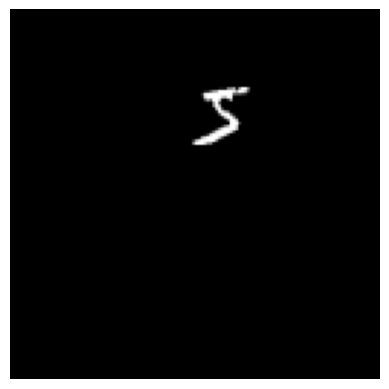

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Synthetic MNIST Detection Data
def make_synthetic_mnist_data(num_samples=1000, image_size=128):
    (x, y), _ = tf.keras.datasets.mnist.load_data()
    images, labels = [], []

    for i in range(num_samples):
        canvas = np.zeros((image_size, image_size), dtype=np.float32)
        digit = tf.image.resize(x[i % len(x)][..., np.newaxis], (28, 28)) / 255.0

        x_offset = np.random.randint(0, image_size - 28)
        y_offset = np.random.randint(0, image_size - 28)
        canvas[y_offset:y_offset + 28, x_offset:x_offset + 28] = digit[..., 0]

        cx = (x_offset + 14) / image_size
        cy = (y_offset + 14) / image_size
        w = 28 / image_size
        h = 28 / image_size

        images.append(canvas[..., np.newaxis])
        labels.append([cx, cy, w, h, y[i % len(y)]])

    return np.array(images), np.array(labels)

# 2. IoU 계산
def compute_iou(box1, box2):
    box1 = tf.convert_to_tensor(box1)
    box2 = tf.convert_to_tensor(box2)

    box1_xy = box1[..., :2]
    box1_wh = box1[..., 2:4]
    box1_min = box1_xy - box1_wh / 2
    box1_max = box1_xy + box1_wh / 2

    box2_xy = box2[..., :2]
    box2_wh = box2[..., 2:4]
    box2_min = box2_xy - box2_wh / 2
    box2_max = box2_xy + box2_wh / 2

    intersect_min = tf.maximum(box1_min, box2_min)
    intersect_max = tf.minimum(box1_max, box2_max)
    intersect_wh = tf.maximum(intersect_max - intersect_min, 0.0)
    intersect_area = intersect_wh[..., 0] * intersect_wh[..., 1]

    area1 = box1_wh[..., 0] * box1_wh[..., 1]
    area2 = box2_wh[..., 0] * box2_wh[..., 1]
    union = area1 + area2 - intersect_area
    return intersect_area / tf.maximum(union, 1e-6)

# 3. YOLO 타깃 인코딩
def encode_labels(labels, grid_size=8, anchors=[[0.2, 0.2], [0.4, 0.4], [0.6, 0.6]], num_classes=10):
    batch_size = labels.shape[0]
    y_true = np.zeros((batch_size, grid_size, grid_size, len(anchors), 5 + num_classes), dtype=np.float32)

    for b in range(batch_size):
        cx, cy, w, h, cls = labels[b]
        grid_x = int(cx * grid_size)
        grid_y = int(cy * grid_size)

        best_iou = 0
        best_anchor = 0
        for i, anchor in enumerate(anchors):
            iou = compute_iou([cx, cy, w, h], [cx, cy, anchor[0], anchor[1]])
            if iou > best_iou:
                best_iou = iou
                best_anchor = i

        tx = cx * grid_size - grid_x
        ty = cy * grid_size - grid_y
        tw = w / anchors[best_anchor][0]
        th = h / anchors[best_anchor][1]

        y_true[b, grid_y, grid_x, best_anchor, 0:4] = [tx, ty, tw, th]
        y_true[b, grid_y, grid_x, best_anchor, 4] = 1.0
        y_true[b, grid_y, grid_x, best_anchor, 5 + int(cls)] = 1.0

    return y_true

# 4. 모델 정의
def yolo_anchor_model(input_shape=(128, 128, 1), grid_size=8, num_anchors=3, num_classes=10):
    inputs = tf.keras.Input(shape=input_shape)
    x = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.MaxPooling2D(2)(x)
    x = tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(grid_size * grid_size * num_anchors * (5 + num_classes))(x)
    x = tf.keras.layers.Reshape((grid_size, grid_size, num_anchors, 5 + num_classes))(x)
    return tf.keras.Model(inputs, x)

# 5. Loss 함수
def yolov2_loss(y_true, y_pred):
    obj_mask = y_true[..., 4:5]
    noobj_mask = 1.0 - obj_mask

    box_loss = tf.reduce_sum(obj_mask * tf.square(y_pred[..., 0:4] - y_true[..., 0:4]))
    obj_loss = tf.reduce_sum(obj_mask * tf.square(y_pred[..., 4:5] - y_true[..., 4:5]))
    noobj_loss = tf.reduce_sum(noobj_mask * tf.square(y_pred[..., 4:5]))
    class_loss = tf.reduce_sum(obj_mask * tf.square(y_pred[..., 5:] - y_true[..., 5:]))
    return box_loss + obj_loss + 0.5 * noobj_loss + class_loss

# 6. 학습
images, raw_labels = make_synthetic_mnist_data(1000)
yolo_labels = encode_labels(raw_labels, grid_size=8)
model = yolo_anchor_model()
model.compile(optimizer='adam', loss=yolov2_loss)
model.fit(images, yolo_labels, epochs=3, batch_size=16)

# 7. 예측 결과 디코딩 및 시각화
def decode_predictions(pred, anchors=[[0.2, 0.2], [0.4, 0.4], [0.6, 0.6]], conf_threshold=0.5):
    pred = pred[0]  # (S, S, A, 5+C)
    grid_size = pred.shape[0]
    boxes = []

    for y in range(grid_size):
        for x in range(grid_size):
            for a in range(len(anchors)):
                tx, ty, tw, th, obj = pred[y, x, a, :5]
                if obj < conf_threshold:
                    continue
                cx = (x + tx) / grid_size
                cy = (y + ty) / grid_size
                w = anchors[a][0] * tw
                h = anchors[a][1] * th
                class_id = np.argmax(pred[y, x, a, 5:])
                boxes.append([cx, cy, w, h, obj, class_id])
    return boxes

def show_prediction(image, boxes):
    image = (image * 255).astype(np.uint8)
    image = np.stack([image.squeeze()] * 3, axis=-1)
    h, w = image.shape[:2]
    for box in boxes:
        cx, cy, bw, bh, conf, cls = box
        x1 = int((cx - bw / 2) * w)
        y1 = int((cy - bh / 2) * h)
        x2 = int((cx + bw / 2) * w)
        y2 = int((cy + bh / 2) * h)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
        cv2.putText(image, f"{int(cls)}:{conf:.2f}", (x1, y1 - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

# 8. 추론
test_img = images[0:1]
pred = model.predict(test_img)
boxes = decode_predictions(pred)
show_prediction(test_img[0], boxes)
